# Example Brick Building

## Building an 80-20 Brick

Networks with 80 percent excitatory and 20 percent inhibitory connectivity are common and can be used, for 
example, as a liquid in a reservoir computing method (e.g. LSM). This tutorial builds a quick bricks for such a network.  First, some imports:

In [1]:
import numpy as np
np.random.seed(0)
import networkx as nx
import fugu
from fugu import Scaffold, Brick
from fugu.bricks import Vector_Input
from fugu.backends import snn_Backend

def plot_spike_raster(scaffold, results):
    import matplotlib.pyplot as plot
    num_elements=scaffold.graph.number_of_nodes()
    print('Number of neurons: ', num_elements)
    results.plot.scatter(x='time', y='neuron_number', title="Spike Raster")
    plot.show()
    
def plot_scaffold_graph(scaffold):
    edge_weights = [scaffold.graph.edges[v]['weight'] for v in scaffold.graph.edges()]
    nx.draw_networkx(scaffold.graph, 
                 with_labels = False, 
                 pos = nx.spring_layout(scaffold.graph),
                 edge_color = edge_weights,
                 node_size = 100)

All bricks should inherit from the `Brick` class.  Bricks that are listed as input bricks should instead inherit from `InputBrick`, which is beyond the scope of this tutorial.  The construction of most brick types is similar; constructing a brick that takes input coding "current" (see below) is a bit different and is beyond the scope of this tutorial.


The `Brick` class provides the framework for the a scaffold to build a neural graph. Subclasses of `Brick` should provide the actual code that will generate the nodes and edges on a graph.  The graph construction should take place within the `build` method.  Let's look at the definition of the parent class `Brick`.

```python 
class Brick(ABC):
    def __init__(self):
        self.name = "Empty Brick"
        self.supported_codings = []

    @abstractmethod
    def build(self, graph,
                   metadata,
                   complete_node,
                   input_lists,
                   input_codings):
        pass

```


The first line `class Brick(ABC)` defines the abstract class of `Brick`.  Brick objects inherit from `ABC` which just means that `Brick` is an abstract class that cannot be instantiated on its own; only subclasses may be instantiated.

The ``__init__`` method contains standard instantiation code.  All bricks are expected to have a member property `self.name` that is unique to the brick.  The uniqueness needs to be determined by the scaffold, not by the brick.

The property `self.is_built` is a boolean that is True if the brick has been built (added to the graph).

The property `self.supported_codings` is a list of input codings (strings) that the brick supports.  Since you have the full use of python when you are defining your brick, you can support multiple coding types completely transparent to the user.  A full list of coding types can be found at `fugu.input_coding_types`.

The method `build` will be called by the scaffold when the graph is to be built.  Arguments are:
- graph: The graph object that we are building onto.
- metadata: A dictionary of shapes and parameters. This will likely be removed in future implementations, so don't rely on it.
- control_nodes: A *dict* of *lists* of nodes that transmit a control information.  The most common is `control_nodes['complete']` which carries a list of 'finished' spikes from input bricks.  If your brick has one input, then this will be a list of a single node.  The only other currently used key is `control_nodes['begin']` which is used for temporally coded bricks (and outside the scope of this tutorial)
- input_lists:  A *list of lists* of nodes that correspond to input neurons. The outermost list contains a list of neurons, one for each input on the scaffold.  
- input_codings: A *list* of input coding types. The list contains one coding type per input on the scaffold.

Each brick is responsible for throwing the appropriate errors/warnings if the inputs are not compatible with the brick.

In [2]:
class eighty_twenty(Brick):
    def __init__(self, 
                 name=None, 
                 liquid_size = 128, 
                 runtime = 25,
                 connection_sparsity = 0.1,
                 ):
        super().__init__()
        self.runtime = runtime
        self.liquid_size = liquid_size
        self.connection_sparsity = connection_sparsity
        
        #The brick hasn't been built yet.
        self.is_built = False
        #metadata isn't really used right now.
        self.metadata = dict()
        #We just store the name passed at construction.
        self.name = name
        #For this example, we'll let any input coding work even though the answer might not make sense.
        self.supported_codings = fugu.input_coding_types
    def build(self,
             graph,
             metadata,
             control_nodes,
             input_lists,
             input_codings):
        #Expect 1 input
        if len(input_codings)!=1:
            raise ValueError('Only one input supported.')
        output_coding = 'Raster'
        
        #We'll need to do some record keeping
        excitatory_neurons = []
        output_neurons = []
        
        #Defining the liquid
        for neuron_number in range(self.liquid_size):
            neuron_name = self.name + '_{}'.format(neuron_number)
            graph.add_node(neuron_name,
                           index = neuron_number,
                           threshold = 1.0,
                           decay = 0.25,
                           p = 1.0)
            if np.random.rand() < 0.8:
                excitatory_neurons.append(neuron_name)
            output_neurons.append(neuron_name)
        #Connecting within the liquid
        for presynaptic_neuron in output_neurons:
            for postsynaptic_neuron in output_neurons:
                if np.random.rand() > self.connection_sparsity:
                    continue
                if presynaptic_neuron == postsynaptic_neuron:
                    continue
                weight = 1.5 if presynaptic_neuron in excitatory_neurons else -2.5
                
                graph.add_edge(presynaptic_neuron,
                              postsynaptic_neuron,
                              weight=weight,
                              delay = 1)
                
        #Connecting the input to the liquid
        #We'll just do a 1-to-1 connection, but you could do whatever you want here
        for neuron_number, input_neuron in enumerate(input_lists[0]):
            liquid_neuron_number = neuron_number % self.liquid_size
            liquid_neuron_name = self.name + '_{}'.format(liquid_neuron_number)
            graph.add_edge(input_neuron,
                           liquid_neuron_name,
                           weight = 1.5,
                           delay = 1
                          )
        
        
        #All bricks should provide a neuron that spikes when the brick has completed processing.
        new_complete_node_name = self.name + '_complete'
        graph.add_node(new_complete_node_name,
                      index = -1,
                      threshold = 0.0,
                      decay =0.0,
                      p=1.0,
                      potential=0.0)
        graph.add_edge(control_nodes[0]['complete'], new_complete_node_name,weight=1.0,delay=self.runtime)
        
        
        #We will also provide a neuron that spikes when the brick has started processing.
        #This is useful for time evolving bricks
        new_begin_node_name = self.name + '_begin'
        graph.add_node(new_begin_node_name,
                       index = -2,
                       threshold = 0.0,
                       decay = 0.0,
                       p=1.0,
                       potential = 0.0)
        graph.add_edge(control_nodes[0]['complete'], new_begin_node_name, weight=1.0, delay=1)
        
        self.is_built = True #We're done
        
        return (graph,
               self.metadata,
               [{'complete': new_complete_node_name,'begin':new_begin_node_name}],
               [output_neurons],
               [output_coding])


## Building a Testing Scaffold

We'll now create some dummy data and a simple scaffold to test our new brick!

In [3]:
num_input_neurons = 100
random_spikes = np.random.binomial(1, 0.2, size=(num_input_neurons,)) #20% of our inputs neurons randomly spike

et_brick = eighty_twenty(name='80-20', liquid_size = 110, connection_sparsity = 0.01)

scaffold = Scaffold()
scaffold.add_brick(Vector_Input(random_spikes, coding='Raster', name='Input0'), 'input' )
scaffold.add_brick(et_brick, (0,0), output=True)
scaffold.lay_bricks()
scaffold.summary()

Scaffold is built: True
-------------------------------------------------------
List of Bricks:


Brick No.: 0
Brick Tag: Input0-1
Brick Name: Input0
{'tag': 'Input0-1', 'name': 'Input0', 'brick': <fugu.bricks.input_bricks.Vector_Input object at 0x7f93732df670>, 'layer': 'input', 'input_nodes': [(-2, 0)], 'output_lists': [['Input0-1:(0,)', 'Input0-1:(1,)', 'Input0-1:(2,)', 'Input0-1:(3,)', 'Input0-1:(4,)', 'Input0-1:(5,)', 'Input0-1:(6,)', 'Input0-1:(7,)', 'Input0-1:(8,)', 'Input0-1:(9,)', 'Input0-1:(10,)', 'Input0-1:(11,)', 'Input0-1:(12,)', 'Input0-1:(13,)', 'Input0-1:(14,)', 'Input0-1:(15,)', 'Input0-1:(16,)', 'Input0-1:(17,)', 'Input0-1:(18,)', 'Input0-1:(19,)', 'Input0-1:(20,)', 'Input0-1:(21,)', 'Input0-1:(22,)', 'Input0-1:(23,)', 'Input0-1:(24,)', 'Input0-1:(25,)', 'Input0-1:(26,)', 'Input0-1:(27,)', 'Input0-1:(28,)', 'Input0-1:(29,)', 'Input0-1:(30,)', 'Input0-1:(31,)', 'Input0-1:(32,)', 'Input0-1:(33,)', 'Input0-1:(34,)', 'Input0-1:(35,)', 'Input0-1:(36,)', 'Input0-1:(37,)', '

## Plotting and Running
We can also plot our scaffold.graph and then run it on a simulator backend.

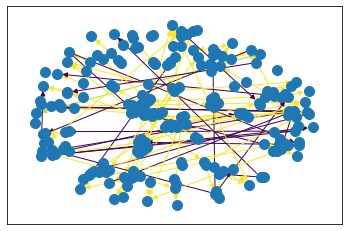

In [4]:
plot_scaffold_graph(scaffold)

In [5]:
backend = snn_Backend()
backend_args = {}
backend.compile(scaffold, backend_args)
result = backend.run(30)
print(result)

     time  neuron_number
0     1.0          109.0
1     1.0          110.0
2     1.0          115.0
3     1.0          119.0
4     1.0          121.0
..    ...            ...
134   8.0          195.0
135   9.0          110.0
136   9.0          142.0
137   9.0          164.0
138  10.0          142.0

[139 rows x 2 columns]


Number of neurons:  214


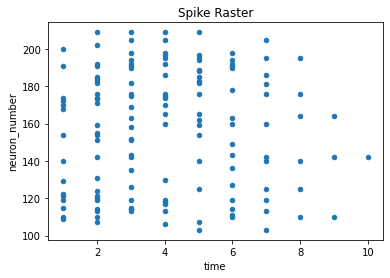

In [6]:
plot_spike_raster(scaffold, result)

## Trying a new initalization

Because we used parameters for our 80-20 liquid, it's pretty easy to go ahead and modify those.

We'll try using slightly higher connection sparsity.

In practice, we could've allowed for much more functionality, such as:
- Loading a weight matrix
- Drawing weights from a distribution
- Having variable delays
- Random connections from the input brick

In [21]:
et_brick = eighty_twenty(name='80-20', liquid_size = 110, connection_sparsity = 0.015)

scaffold = Scaffold()
scaffold.add_brick(Vector_Input(random_spikes, coding='Raster', name='Input0'), 'input' )
scaffold.add_brick(et_brick, (0,0), output=True)
scaffold.lay_bricks()
backend.compile(scaffold, backend_args)
result = backend.run(30)

Number of neurons:  214


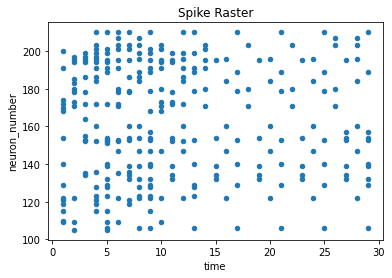

In [22]:
plot_spike_raster(scaffold, result)